In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from classifier import *
torch.cuda.is_available(), torch.backends.cudnn.enabled

/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


(True, True)

In [2]:
PATH = Path('/home/sean/hpc-home/skin_cancer/')
%ls $PATH

dermofit/             test_isic17_dermofitLabels.csv*
ISIC/                 tmp/
isic18_p3_test_data*  train_dermofit_isic17.csv*
models/               val_isic17.csv*


In [3]:
imgd = PATH
dermofit = PATH / 'dermofit'
isic = PATH / 'ISIC'

dcsv_p = dermofit / 'train.csv'
icsv_p = isic / 'train.csv'
icsv_p_te = isic / 'isic17_p3_test_gt.csv'
icsv_p_val = isic / 'Part3_val_gt.csv'

train_csv = PATH / 'train_dermofit_isic17.csv' # created in this script
val_csv = PATH / 'val_isic17.csv'
test_csv = PATH / 'test_isic17_dermofitLabels.csv'
test_folder = 'ISIC/ISIC-2017_Test_v2_Data_Classification/'
val_folder = 'ISIC/ISIC-2017_Validation_Data/' 

ex = (PATH.exists(), icsv_p.is_file(), dcsv_p.is_file())
assert all(ex), 'All files and paths should exist! - {}'.format(ex)

In [4]:
%ls $isic

classification/
isic17_p3_test_gt.csv*
ISIC-2017_Test_v2_Data/
ISIC-2017_Test_v2_Data_Classification/
ISIC-2017_Test_v2_Data_metadata.csv*
ISIC-2017_Test_v2_Part1_GroundTruth/
ISIC-2017_Test_v2_Part3_GroundTruth.csv*
ISIC-2017_Training_Data/
ISIC-2017_Training_Part1_GroundTruth/
ISIC-2017_Training_Part1_GroundTruth.zip*
ISIC-2017_Validation_Data/
ISIC-2017_Validation_Part1_GroundTruth/
models/
Part3_train_gt.csv*
Part3_val_gt.csv*
test_isic17.csv*
test_seg_isic17_data*
test_seg_isic17_gt*
tmp/
train.csv*
valset_download*
valset_gt_download*


In [5]:
%ls $dermofit

AK/      ALLIEC/  ALLSK/    iec.zip*         models/   sk.zip*
ak.zip*  ALLMEL/  ALLVASC/  lesionlist.txt*  PYO/      tmp/
ALLBCC/  ALLML/   bcc.zip*  mel.zip*         pyo.zip*  train.csv*
ALLDF/   ALLSCC/  df.zip*   ml.zip*          scc.zip*  vasc.zip*


## Process CSV for FastAI API

The process for formatting the CSV labels (or other formats) is different for all datasets, so no standard functions. Might have to load labels into a CSV for other datasets (not hard with pandas - pd).

In [6]:
icsv_p.parent.name, dcsv_p.parent.name

('ISIC', 'dermofit')

In [7]:
ddf = pd.read_csv(dcsv_p)
ddf.columns = ['image_id', 'classes']
ddf['image_id'] = str(dcsv_p.parent.name) + '/' + np.array(ddf['image_id']) + '.png'
ddf.set_index('image_id', inplace=True)
ddf.head()

classes
image_id                               
dermofit/ALLBCC/D204a/D204a.png     BCC
dermofit/ALLSCC/D222/D222.png       SCC
dermofit/ALLML/D226b/D226b.png       ML
dermofit/ALLML/D226c/D226c.png       ML
dermofit/ALLML/D227/D227.png         ML

In [20]:
def isic_label_proc(csvn, outcsv=None):
    df = pd.read_csv(csvn, engine='python')
    df.set_index('image_id', inplace=True)
    # get classes
    mel_id = np.array(df['melanoma']) == 1
    classes = np.zeros(mel_id.shape).astype(str)
    classes[mel_id] = 'melanoma'

    sk_id = np.array(df['seborrheic_keratosis']) == 1
    assert np.intersect1d(np.where(mel_id), np.where(sk_id)).shape[0] == 0
    classes[sk_id] = 'seborrheic_keratosis'
    classes[classes == '0.0'] = 'nevus'
    df['classes'] = classes
    
    dfset = df[['classes']].copy()
    if outcsv: 
        dfset['classes'].value_counts().plot(kind='barh')
        dfset.to_csv(outcsv)
    return dfset

def isic2dermofit(idf, fn):
    idf.columns = ['image_id', 'classes']
    idf['image_id'] = fn + np.array(idf['image_id']) + '.jpg'
    idf.set_index('image_id', inplace=True)
    idf['classes'].replace('nevus', 'ML', inplace=True)
    idf['classes'].replace('melanoma', 'MEL', inplace=True)
    idf['classes'].replace('seborrheic_keratosis', 'SK', inplace=True)
    return idf

def load_isic17_ds(fn, folder):
    return isic2dermofit(pd.read_csv(fn), fn.parent.name + folder)

In [22]:
testdf = isic_label_proc(icsv_p_te)
# testdf['image_id'] = fn + np.array(idf['image_id']) + '.jpg'
testdf.index = test_folder + testdf.index.values + '.jpg'
testdf['classes'].replace('nevus', 'ML', inplace=True)
testdf['classes'].replace('melanoma', 'MEL', inplace=True)
testdf['classes'].replace('seborrheic_keratosis', 'SK', inplace=True)
testdf.to_csv(test_csv)
testdf.head()

classes
ISIC/ISIC-2017_Test_v2_Data_Classification/ISIC...      SK
ISIC/ISIC-2017_Test_v2_Data_Classification/ISIC...      ML
ISIC/ISIC-2017_Test_v2_Data_Classification/ISIC...      ML
ISIC/ISIC-2017_Test_v2_Data_Classification/ISIC...      SK
ISIC/ISIC-2017_Test_v2_Data_Classification/ISIC...      SK

In [119]:
valdf = isic_label_proc(icsv_p_val)
valdf.index = val_folder + valdf.index.values + '.jpg'
valdf['classes'].replace('nevus', 'ML', inplace=True)
valdf['classes'].replace('melanoma', 'MEL', inplace=True)
valdf['classes'].replace('seborrheic_keratosis', 'SK', inplace=True)
valdf['classes'].head()
valdf.to_csv(val_csv)
# val_indexes = valdf.index.values

In [89]:
idf = load_isic17_ds(icsv_p, '/ISIC-2017_Training_Data/')
idf.head()

classes
image_id                                             
ISIC/ISIC-2017_Training_Data/ISIC_0000000.jpg      ML
ISIC/ISIC-2017_Training_Data/ISIC_0000001.jpg      ML
ISIC/ISIC-2017_Training_Data/ISIC_0000002.jpg     MEL
ISIC/ISIC-2017_Training_Data/ISIC_0000003.jpg      ML
ISIC/ISIC-2017_Training_Data/ISIC_0000004.jpg     MEL

In [9]:
tdf = pd.concat([idf, ddf])
tdf.head(), tdf.tail()

(                                              classes
 image_id                                             
 ISIC/ISIC-2017_Training_Data/ISIC_0000000.jpg      ML
 ISIC/ISIC-2017_Training_Data/ISIC_0000001.jpg      ML
 ISIC/ISIC-2017_Training_Data/ISIC_0000002.jpg     MEL
 ISIC/ISIC-2017_Training_Data/ISIC_0000003.jpg      ML
 ISIC/ISIC-2017_Training_Data/ISIC_0000004.jpg     MEL,
                                 classes
 image_id                               
 dermofit/ALLIEC/D649a/D649a.png     IEC
 dermofit/ALLIEC/G40a/G40a.png       IEC
 dermofit/ALLIEC/P100/P100.png       IEC
 dermofit/ALLIEC/T239/T239.png       IEC
 dermofit/ALLIEC/T39/T39.png         IEC)

In [6]:
tdf = pd.read_csv(train_csv)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6585e13710>, ML      1703
 SK       511
 MEL      450
 BCC      239
 VASC      97
 SCC       88
 IEC       78
 DF        65
 AK        45
 PYO       24
 Name: classes, dtype: int64, 3300)

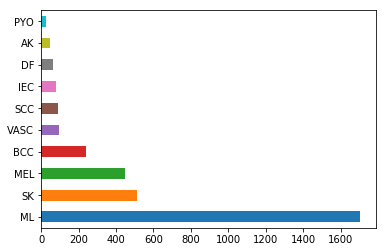

In [7]:
tdf['classes'].value_counts().plot(kind='barh'),  tdf['classes'].value_counts(), len(tdf)

In [11]:
tdf.to_csv(train_csv)

## Data Loaders

In [6]:
# The network architecture to use, resnet34 is a good start, will get better performance with 
# resnext50 or inception_4
arch=resnet34
# image size
sz=224
bs=64

# Dataset augmentations
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down)
# The dataloader, used for training and evaluation, has numerous useful functions for:
# loading data, preprocessing, batching, obtaining basic stats, and more
data = ImageClassifierData.from_csv(PATH, '', train_csv, test_name=test_folder, tfms=tfms, bs=bs)

In [7]:
data.classes, len(data.classes)

(['AK', 'BCC', 'DF', 'IEC', 'MEL', 'ML', 'PYO', 'SCC', 'SK', 'VASC'], 10)

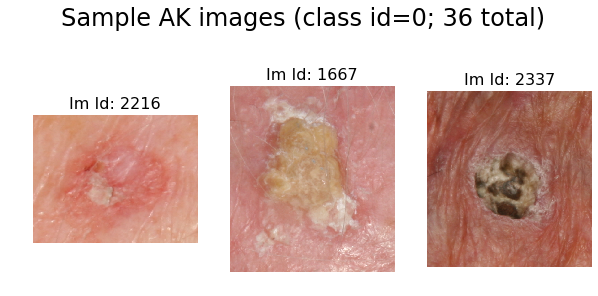

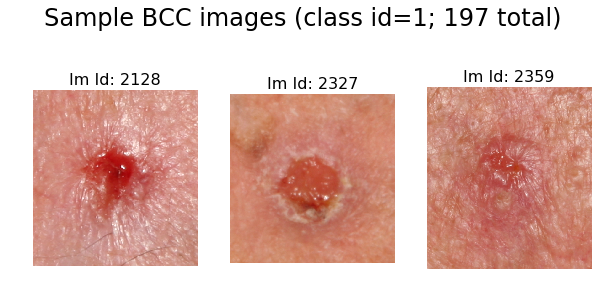

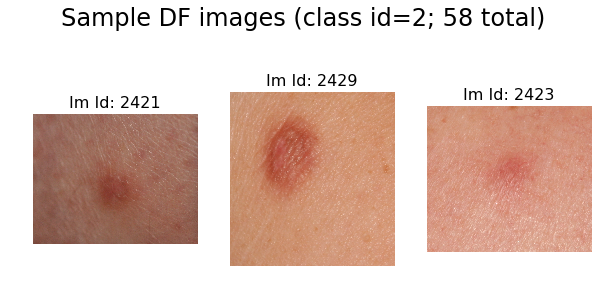

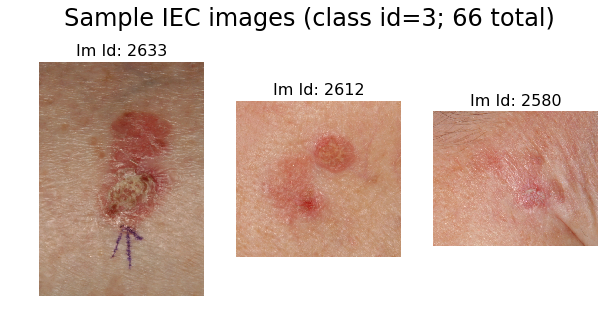

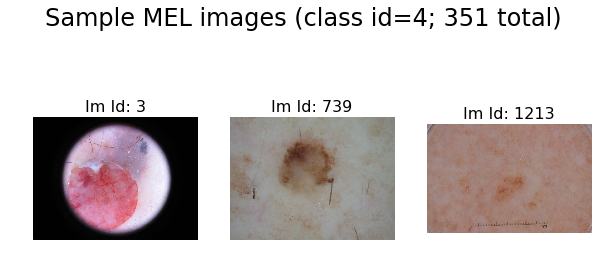

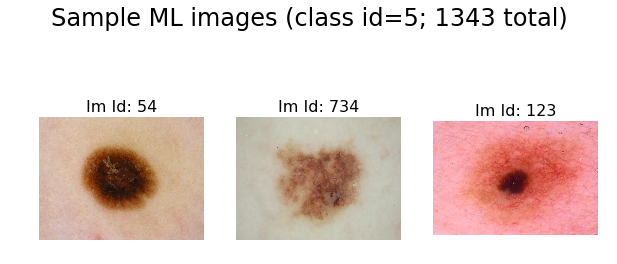

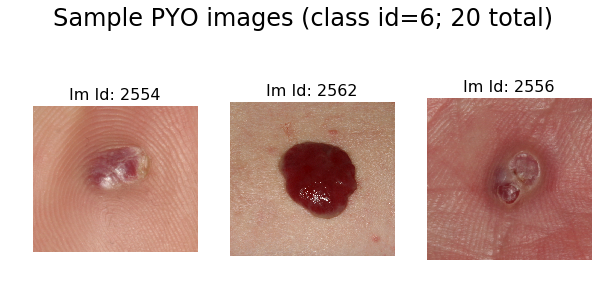

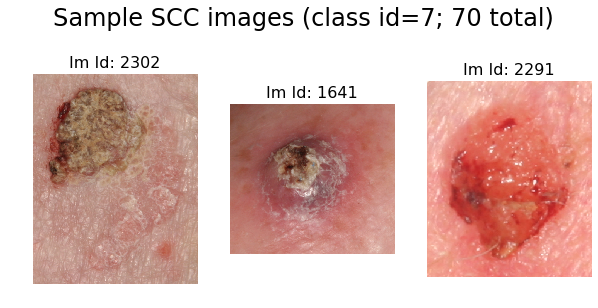

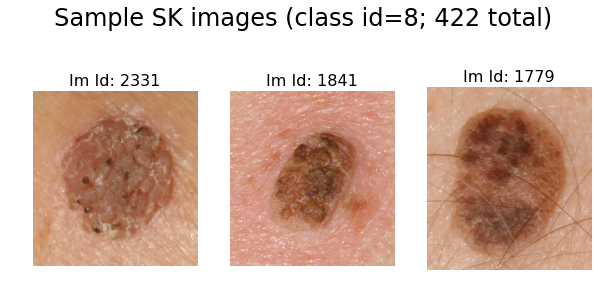

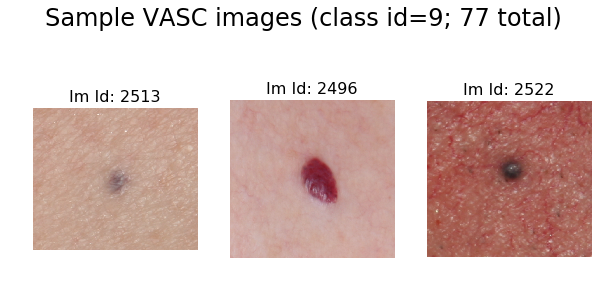

In [8]:
for i in range(min(len(data.classes),10)): sample_ims(PATH, i, data, numimgs=3, figsize=(10,5))

# Setup and Train Network

In [9]:
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load('224dermofit_isic17_2')

If training from scratch or re-training run the below cell

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

This can be used to help find the inital learning rate. 

In [16]:
learn.data.bs = 8
lrf=learn.lr_find()
# learn.sched.plot_lr()

 79%|███████▊  | 33/42 [00:03<00:00,  9.49it/s, loss=2.38]


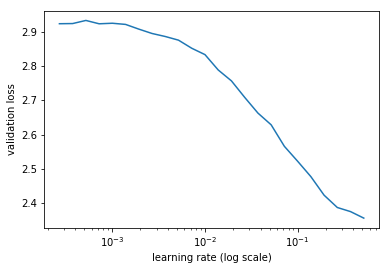

In [17]:
learn.sched.plot()

In [12]:
learn.data.bs = bs

In [18]:
learn.fit(1e-1, 6)

epoch      trn_loss   val_loss   accuracy                 
    0      1.785122   1.27667    0.580303  
    1      1.535402   1.093634   0.642424                 
    2      1.280211   0.926459   0.693939                 
    3      1.034094   0.830846   0.683333                 
    4      0.914533   0.927185   0.704545                  
    5      0.829503   0.782346   0.704545                  



[array([0.78235]), 0.7045454541842143]

In [20]:
# learn.data.bs = max(8, bs // 2)
learn.fit(1e-2, 6, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.614821   0.747757   0.707576  
    1      0.598989   0.745103   0.715152                  
    2      0.572048   0.745001   0.707576                  



[array([0.745]), 0.7075757572145173]

In [21]:
learn.save('224dermofit_isic17_1')

In [10]:
learn.load('224dermofit_isic17_1')

RuntimeError: While copying the parameter named 0.weight, whose dimensions in the model are torch.Size([64, 3, 7, 7]) and whose dimensions in the checkpoint are torch.Size([1024]).

In [22]:
learn.precompute = False
learn.fit(1e-1, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.83174    0.746045   0.718182  
    1      0.823519   0.753652   0.716667                  
    2      0.778368   0.731137   0.70303                   
    3      0.786335   0.765295   0.709091                  
    4      0.768492   0.727445   0.725758                  
    5      0.744023   0.731899   0.716667                  
    6      0.728906   0.73452    0.719697                  



[array([0.73452]), 0.7196969693357295]

In [ ]:
learn.sched.plot_lr()

In [23]:
learn.save('224dermofit_isic17_2')

In [11]:
learn.load('224dermofit_isic17_2')

# Evaluations and Visualisations

Accuracy = 0.74                              
Confusion Matrix:
[[  2   5   0   1   0   0   0   0   1   0]
 [  0  35   1   0   0   2   0   2   1   1]
 [  0   0   7   0   0   0   0   0   0   0]
 [  0   1   1   7   1   1   0   0   1   0]
 [  0   1   4   2  32  56   0   0   3   1]
 [  0   1   0   0  10 321   0   1  27   0]
 [  0   0   0   0   0   0   2   1   0   1]
 [  1   4   0   1   0   0   0   9   3   0]
 [  1   6   0   1   2  20   0   0  59   0]
 [  0   3   1   0   0   0   0   0   0  16]]
AUC for class 0, id AK = 0.97
AUC for class 1, id BCC = 0.98
AUC for class 2, id DF = 1.00
AUC for class 3, id IEC = 0.99
AUC for class 4, id MEL = 0.85
AUC for class 5, id ML = 0.90
AUC for class 6, id PYO = 1.00
AUC for class 7, id SCC = 0.97
AUC for class 8, id SK = 0.92
AUC for class 9, id VASC = 0.99
----------------------------------------
[[  2   5   0   1   0   0   0   0   1   0]
 [  0  35   1   0   0   2   0   2   1   1]
 [  0   0   7   0   0   0   0   0   0   0]
 [  0   1   1   7   1   1   

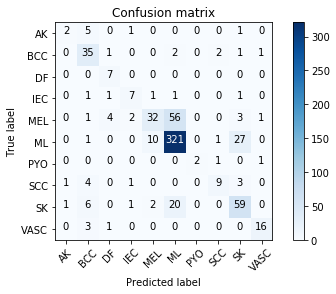

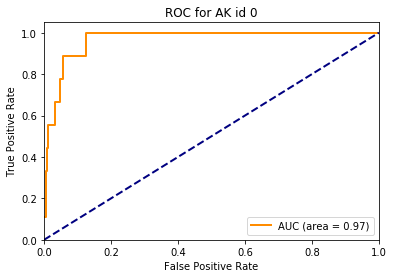

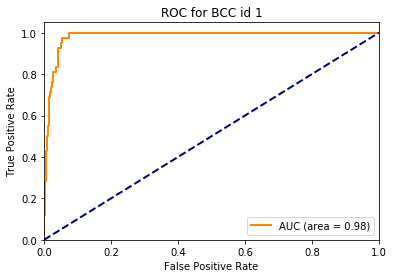

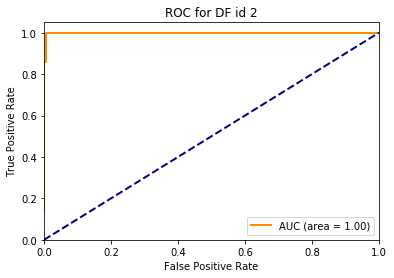

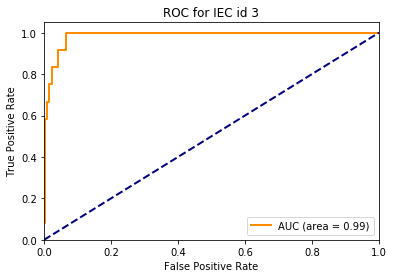

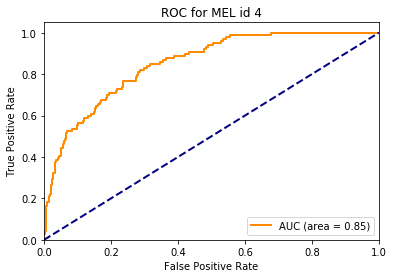

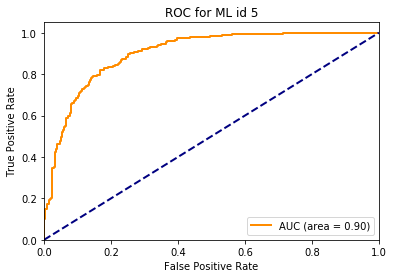

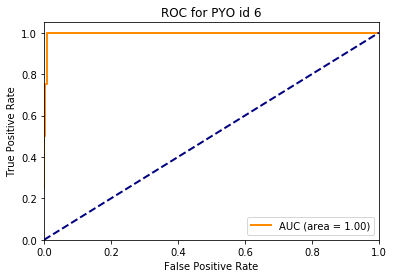

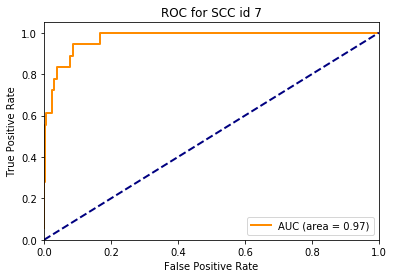

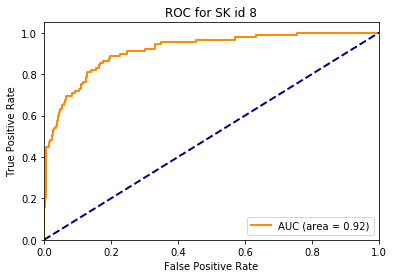

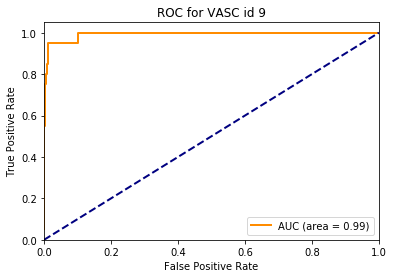

In [12]:
vf_preds, vy, vacc, vcm, vroc_auc, vfpr, vtpr = run_test(learn, sf=True)

Loading ys from csv; shape (600,); vals [0 1 2]
Accuracy = 0.00
Confusion Matrix:
[[  0   0   0  17  75  25   0]
 [  0   0   0  55 257  81   0]
 [  0   0   2  13  61  13   1]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]
AUC for class 0, id AK = 0.50
AUC for class 1, id BCC = 0.49
AUC for class 2, id DF = 0.56
AUC for class 3, id IEC = nan
AUC for class 4, id MEL = nan
AUC for class 5, id ML = nan
AUC for class 6, id PYO = nan
AUC for class 7, id SCC = nan
AUC for class 8, id SK = nan
AUC for class 9, id VASC = nan
----------------------------------------
[[  0   0   0  17  75  25   0]
 [  0   0   0  55 257  81   0]
 [  0   0   2  13  61  13   1]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]


/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples

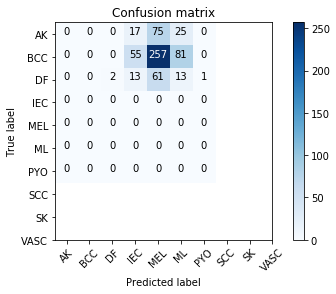

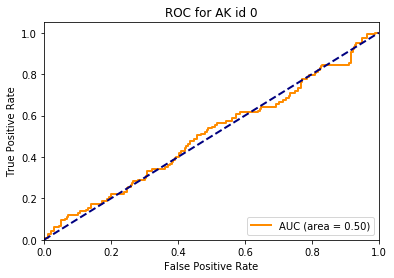

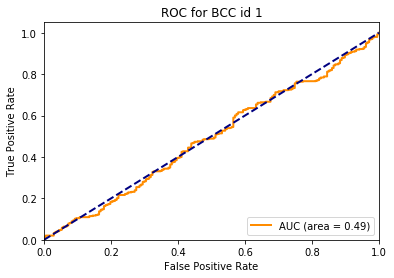

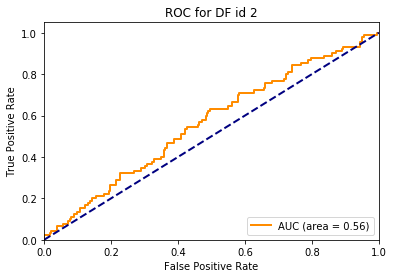

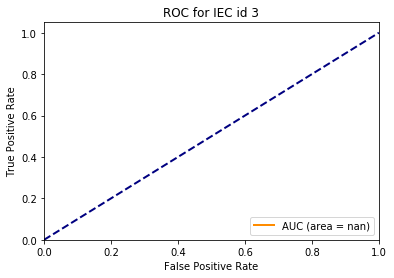

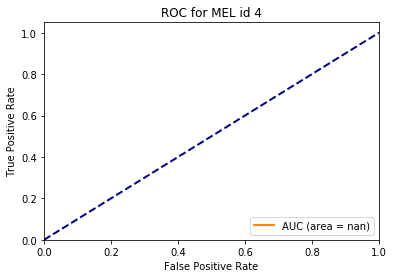

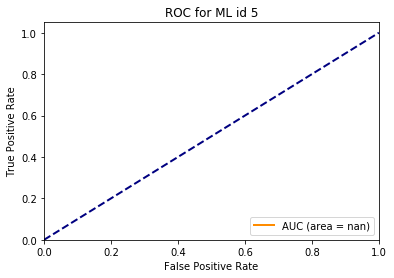

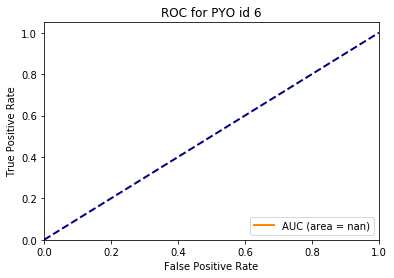

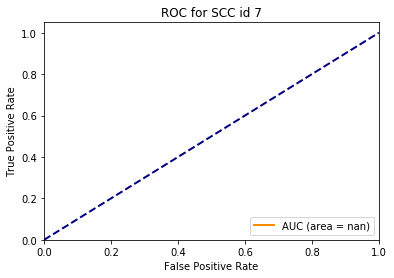

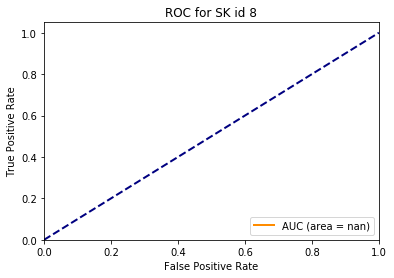

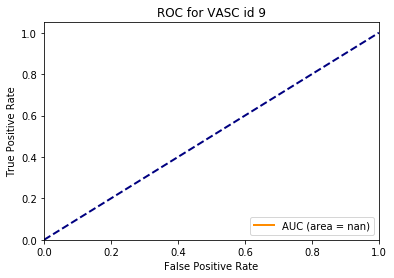

In [25]:
tf_preds, ty, tacc, tcm, troc_auc, tfpr, ttpr = run_test(learn, ts=True, test_csv=test_csv, sf=True)

Text(0.5,1,'Val network predictions distribution')

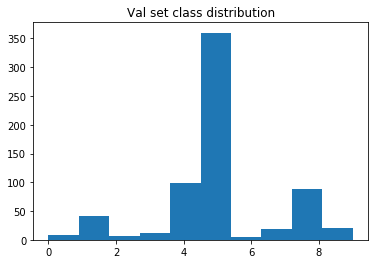

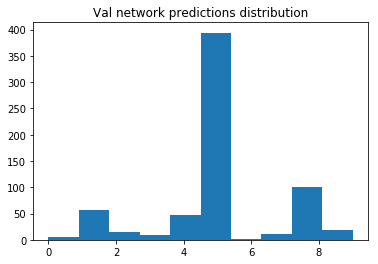

In [25]:
plt.hist(vy, align='mid')
plt.title('Val set class distribution')
plt.figure()
plt.hist(vf_preds, align='mid')
plt.title('Val network predictions distribution')

In [26]:
def visualise(learner, d):
    logpr = learner.predict()
    preds = np.argmax(np.exp(logpr), axis=1)
    probs = logpr[np.arange(logpr.shape[0]), preds]
    plot_val_with_title(d, probs,preds, rand_by_correct(True, preds, d.val_y), "Correctly classified")
    plot_val_with_title(d, probs,preds, rand_by_correct(False, preds, d.val_y), "Incorrectly classified")
    for i, c in enumerate(d.classes):
        plot_val_with_title(d, probs,preds, most_by_correct(i, True, preds, probs, d.val_y), "Most correct {}".format(c))
    

Correctly classified
Incorrectly classified
Most correct AK
Most correct BCC
Most correct DF
Most correct IEC
Most correct MEL
Most correct ML
Most correct PYO
Most correct SCC
Most correct SK
Most correct VASC


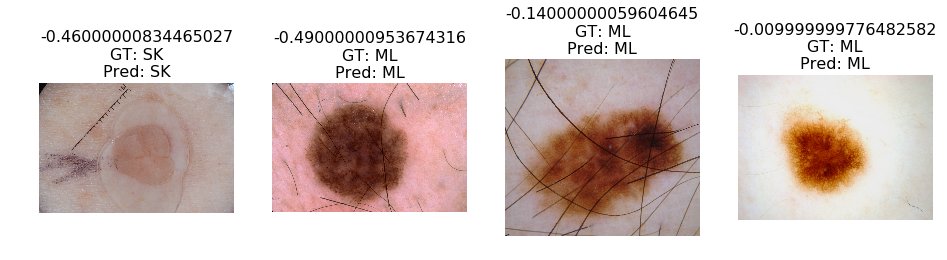

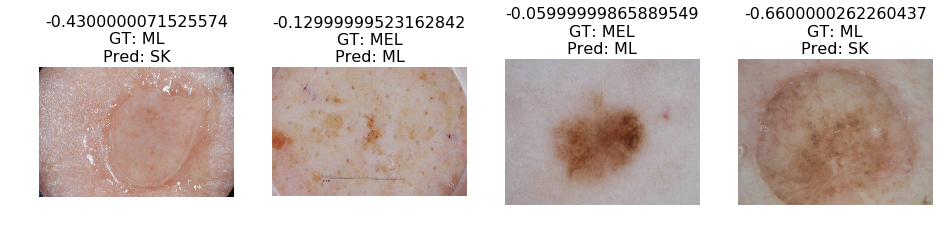

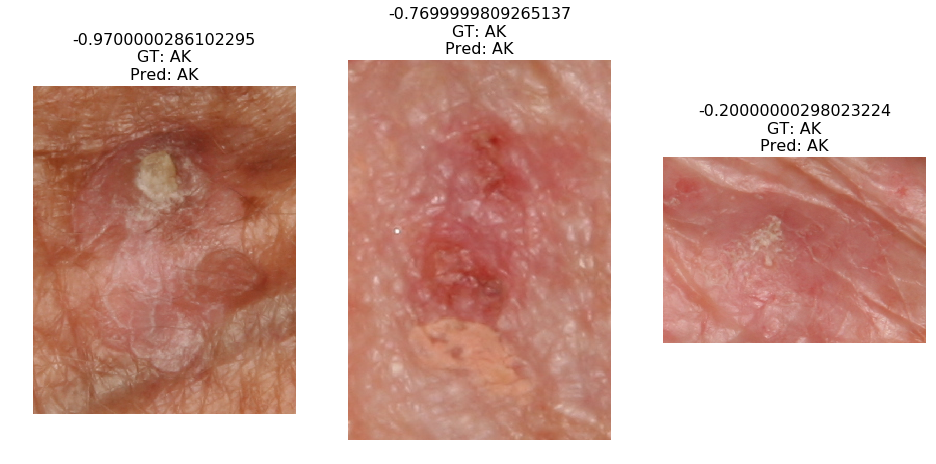

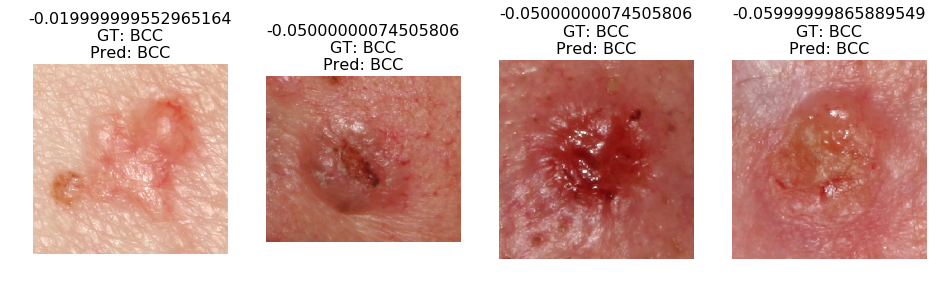

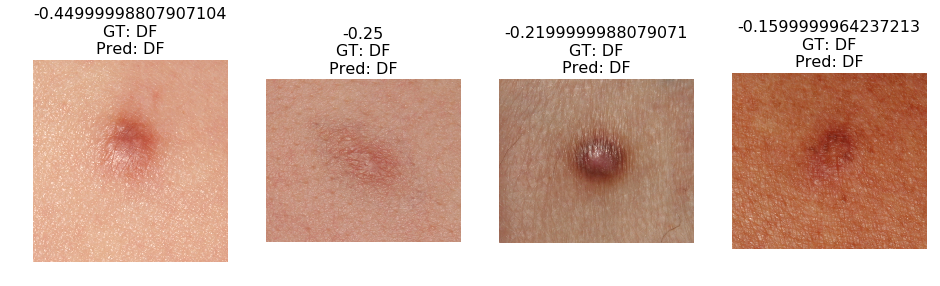

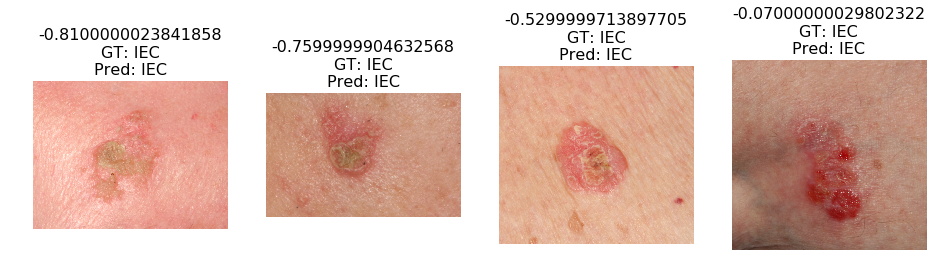

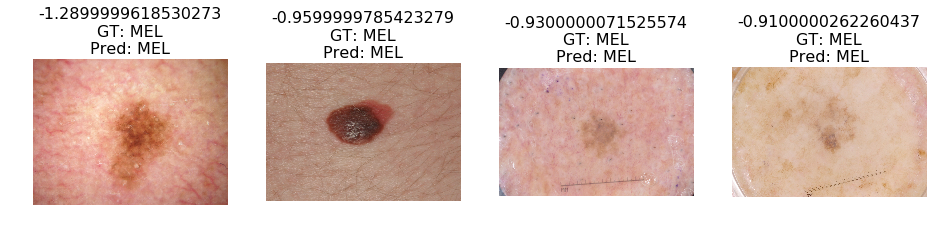

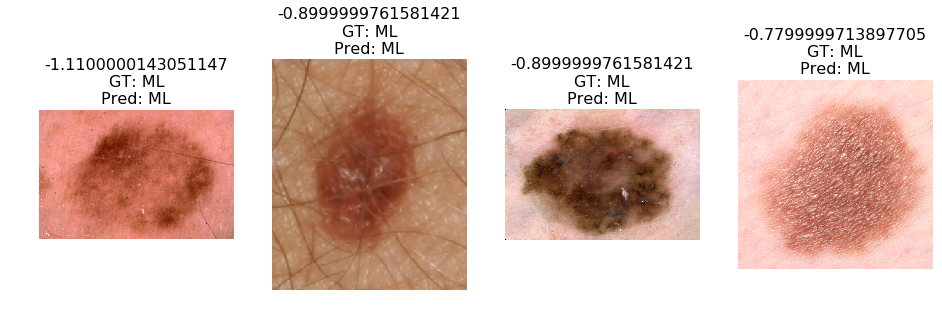

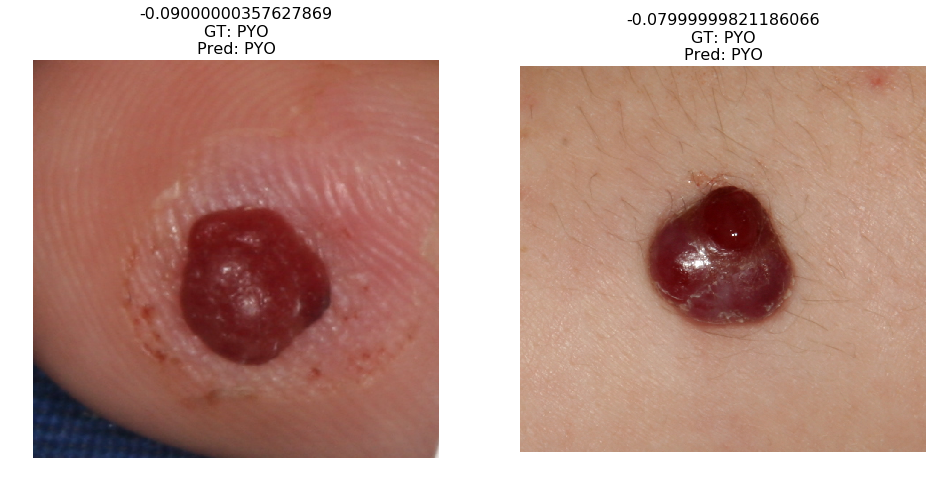

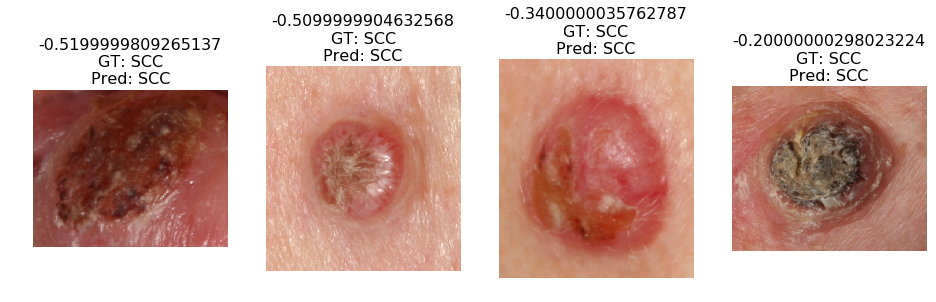

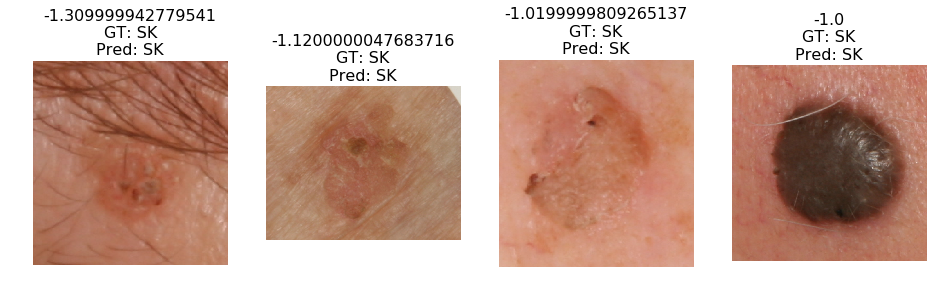

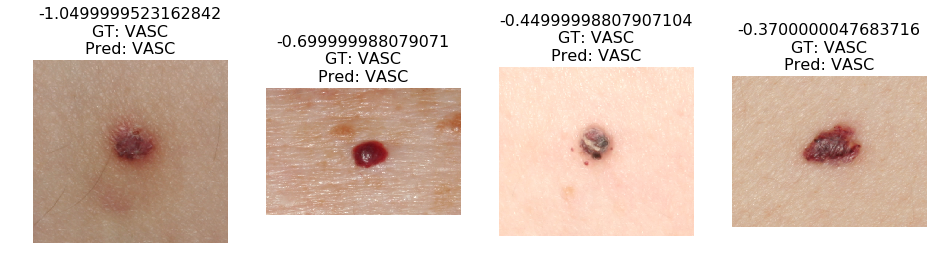

In [27]:
visualise(learn, data)